# <center> Trabajo Semanal 4 <center>
### <center> Autor: Arturo Huber <center>

## Introduccción Teórica

En este trabajo, abordaremos el tema de la estimación espectral de señales. Para ello vamos a estimar la amplitud y frecuencia de señales senoidales con ruido previamente parametrizadas de la siguiente manera:

$$
x(k)=a_0⋅sen(Ω_1⋅n)+n_a(n)
$$

Siendo:

$a_0 = 2$ <br>
$Ω_1= Ω_0+fr⋅2\pi N$ <br>
$Ω_0=\frac{\pi}{2}$ <br>
$f_r \sim \mathcal{U}(-2,2)$ <br>
$n_a \sim \mathcal{N}(0,\sigma^2)$

Vamos a realizar 200 muestras de la señal con un SNR de 3 y 10dB, y aplicarle las ventanas: Rectangular, Flattop, Blackmanharris y Hamming.

Luego, para estimar la amplitud y frecuencia, vamos a usar los siguientes estimadores:

De amplitud $a_1$ :

$$
\hat{a}_1^{(i)} = \left| X_w^{(i)}(\Omega_0) \right| = \left| \mathcal{F}\{ x(n)\cdot w_i(n) \} \right|
$$

Y de frecuencia $\Omega_1$:

$$
\hat{\Omega}_1^{(i)} = \arg \max_{\Omega} \left\{ \, \left| X_w^{(i)}(\Omega) \right| \, \right\}
$$

Y comparar los resultados de los estimadores obtenidos, mediante valores estadisticos, por cada SNR y ventana.

## Analisis y Desarrollo

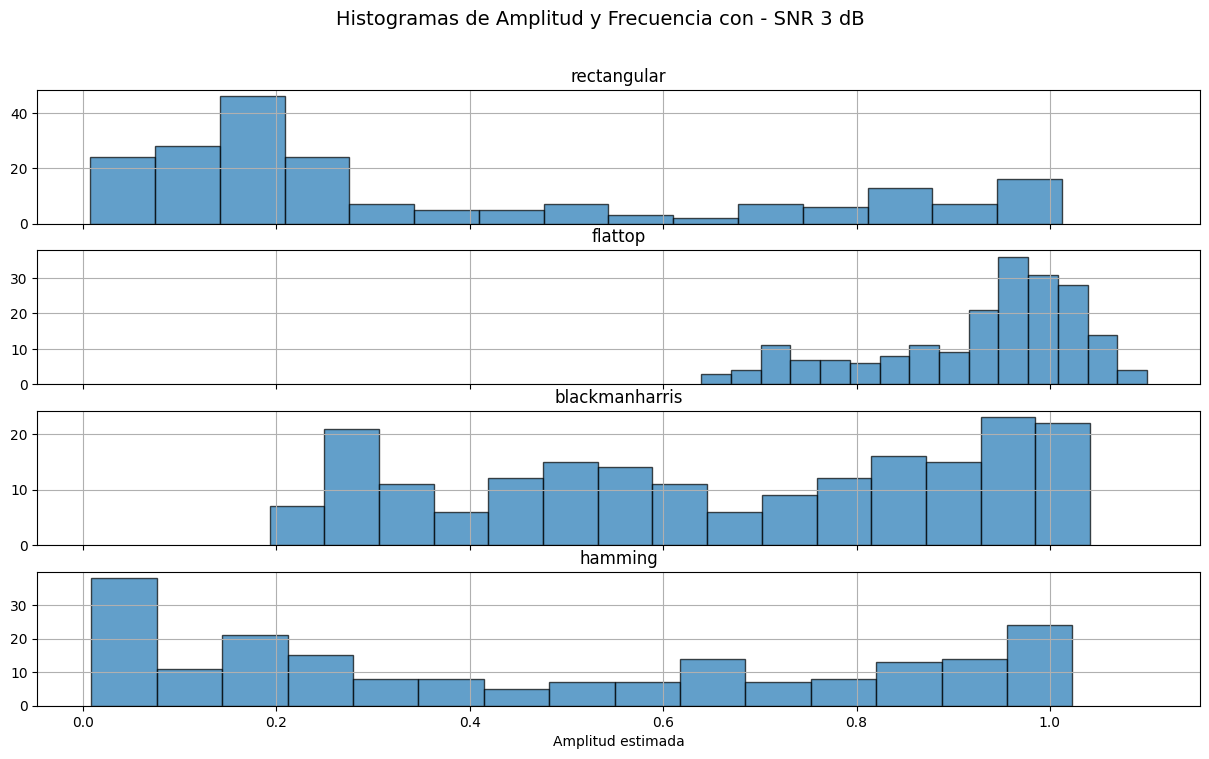

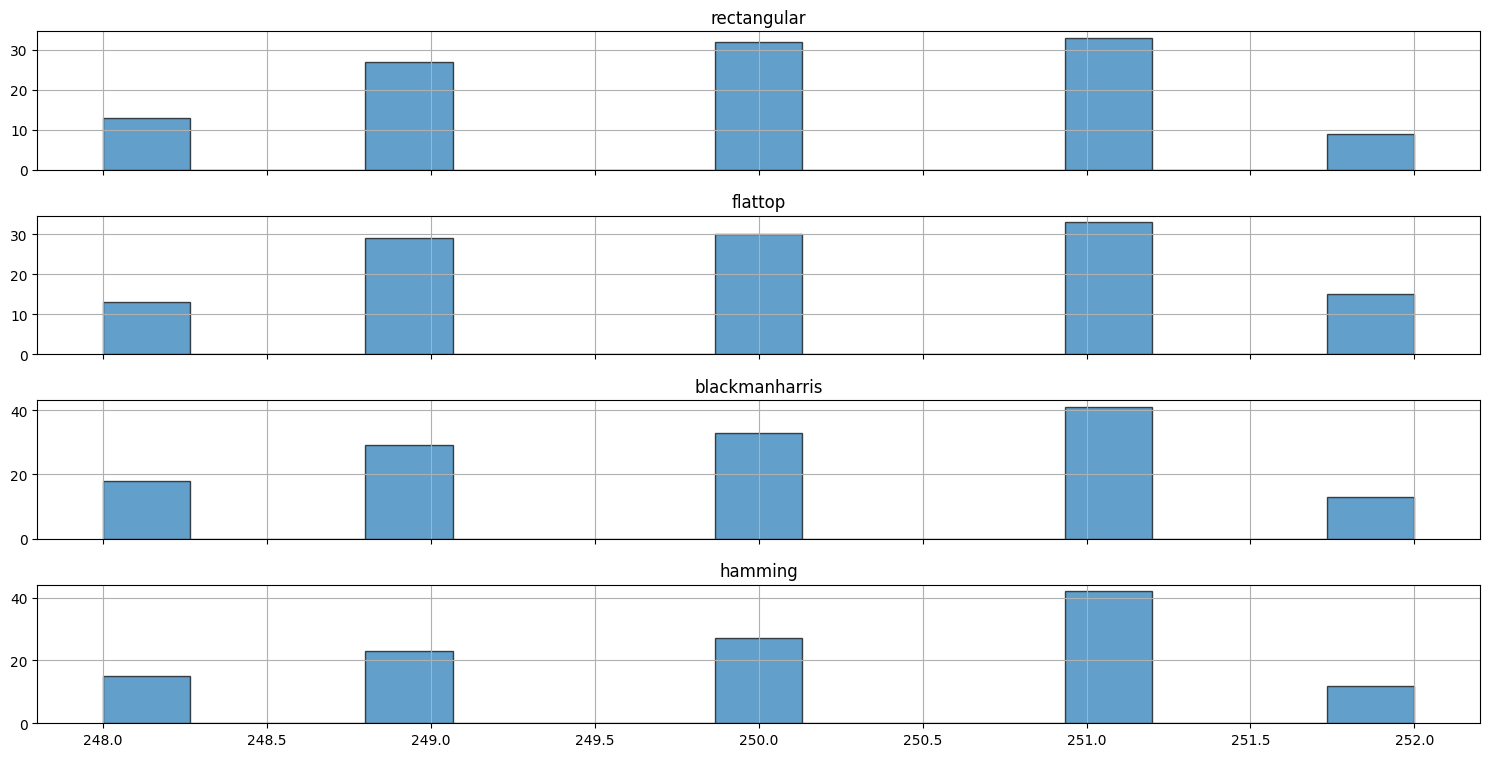

<Figure size 640x480 with 0 Axes>

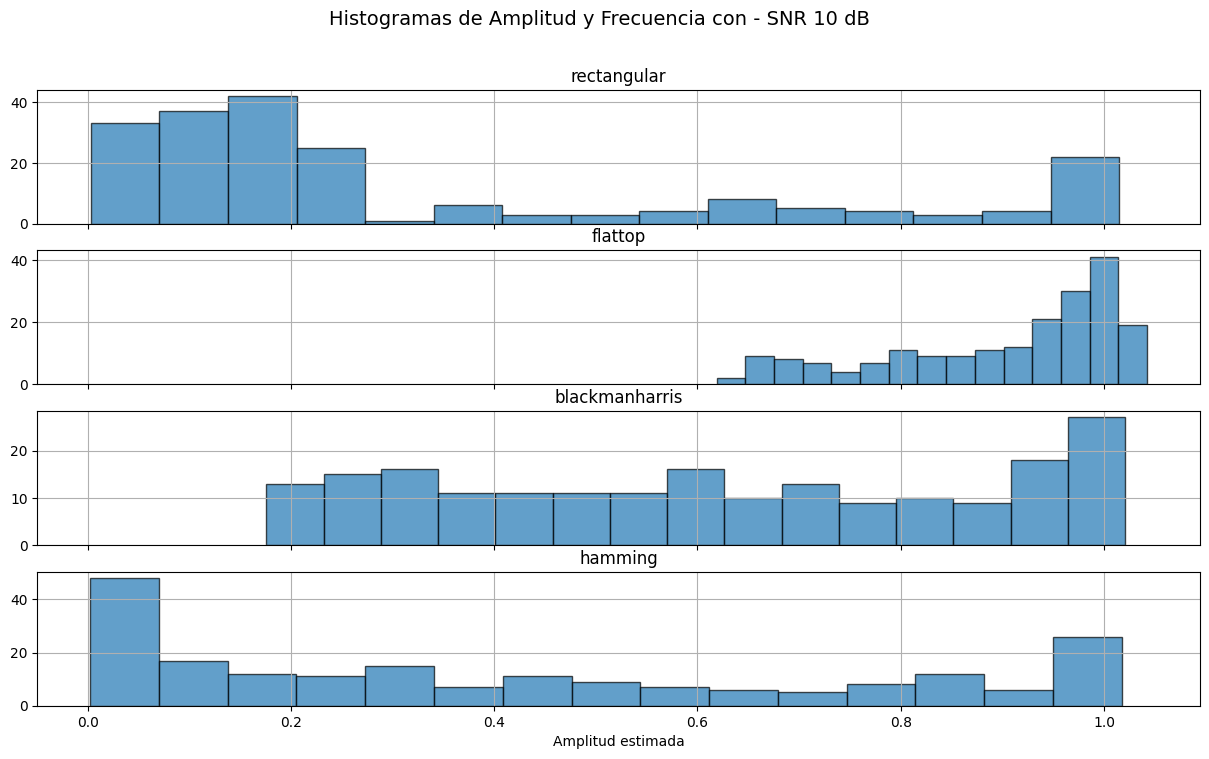

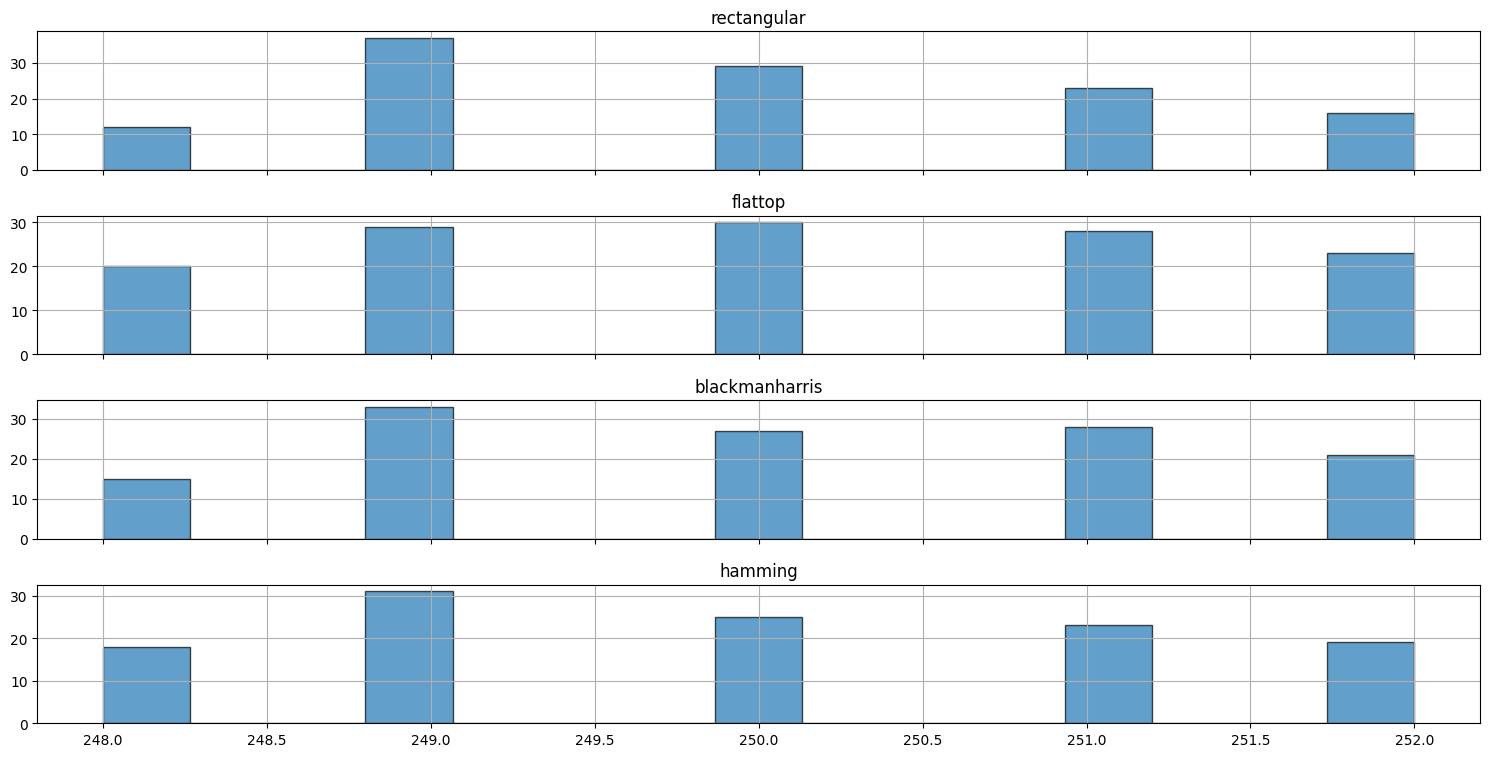

<Figure size 640x480 with 0 Axes>


Resultados para SNR = 3 dB
       Ventana  Bias_Amplitud  Var_Amplitud  Bias_Frecuencia  Var_Frecuencia
   rectangular      -0.894687      0.025271              0.0        0.000021
       flattop      -0.522160      0.002878              0.0        0.000023
blackmanharris      -0.664531      0.016996              0.0        0.000023
       hamming      -0.794890      0.030378              0.0        0.000023

Resultados para SNR = 10 dB
       Ventana  Bias_Amplitud  Var_Amplitud  Bias_Frecuencia  Var_Frecuencia
   rectangular      -0.905706      0.025497              0.0        0.000024
       flattop      -0.527144      0.003150              0.0        0.000028
blackmanharris      -0.693439      0.017536              0.0        0.000027
       hamming      -0.835281      0.030513              0.0        0.000028


In [45]:
import numpy as np
import scipy.signal as sc
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# Parámetros generales
N = 1000
fs = 1000
df = fs / N
R = 200                                 # realizaciones
frecuencia_central = N//4               # Medio de ancho de banda
a0 = 2                                  # amplitud 

SNRs = [3, 10]                          # dB

ventanas = {
    "rectangular": np.ones(N),
    "flattop": sc.windows.flattop(N),
    "blackmanharris": sc.windows.blackmanharris(N),
    "hamming": sc.windows.hamming(N)  
}

# Vector de tiempo
tt_vector = np.arange(N)/fs

resultados = []

for SNR_dB in SNRs:
    
    # Calculo de potencia del ruido
    P_signal = a0**2 / 2
    SNR_linear = 10**(SNR_dB/10)
    pot_ruido = P_signal / SNR_linear
    
    ff_vector = np.random.uniform(-2, 2, R)         # Vector fr

    # Matrices de senos
    tt_columnas = tt_vector.reshape((-1,1))
    ff_filas = ff_vector.reshape((1,-1))
    TT_sen = np.tile(tt_columnas, (1, R))
    FF_sen = np.tile(ff_filas, (N, 1))
    
    # Ruido
    ruido = np.random.normal(loc=0, scale=np.sqrt(pot_ruido), size=(N,R))
    
    # Señales
    xx_sen = a0 * np.sin(2*np.pi*(frecuencia_central + FF_sen)*df*TT_sen)
    xx_sen_ruido = xx_sen + ruido
    
    # Figuras
    fig_a, axes_a = plt.subplots(len(ventanas), 1, figsize=(15, 2*len(ventanas)), sharex=True)
    fig_f, axes_f = plt.subplots(len(ventanas), 1, figsize=(15, 2*len(ventanas)), sharex=True)

    # Ventaneo
    for  i,(win_name, ventana) in enumerate( ventanas.items()):
        
        U = np.sum(ventana)/N                          # Corrección de ganancia de la ventana
        xx_vent = xx_sen_ruido * ventana.reshape(-1,1)
        
        # FFT normalizada
        XX_sen = np.fft.fft(xx_vent, n=N, axis=0)/(N*U)
        freqs = np.fft.fftfreq(N, d=1/fs)
        
        # Estimadores
        a1_est = np.abs(XX_sen[frecuencia_central,:])      #Amplitud
        
        idx_max = np.argmax(np.abs(XX_sen), axis=0)
        Omega1_est = freqs[idx_max]                       
        
        # Filtrar frecuencias fuera del rango [0, fs/2]
        Omega1_est = Omega1_est[(Omega1_est >= 0) & (Omega1_est <= N//2)]  # Frecuencia
        
        # Estadísticos normalizados
        bias_a1 = (np.median(a1_est) - a0) / a0
        var_a1 = (np.var(a1_est, ddof=1)) / (a0**2)
        
        bias_Omega1 = (np.median(Omega1_est) - frecuencia_central) / frecuencia_central
        var_Omega1 = (np.var(Omega1_est, ddof=1)) / (frecuencia_central**2)
        
        resultados.append({
            "SNR_dB": SNR_dB,  
            "Ventana": win_name,
            "Bias_Amplitud": bias_a1,
            "Var_Amplitud": var_a1,
            "Bias_Frecuencia": bias_Omega1,
            "Var_Frecuencia": var_Omega1
        })
        
        # Graficar histogramas
        axes_a[i].hist(a1_est, bins=15,  edgecolor='black', alpha=0.7)
        axes_a[i].set_title(f"{win_name}")
        axes_a[i].grid(True)
        
        axes_f[i].hist(Omega1_est, bins=15,edgecolor='black', alpha=0.7)
        axes_f[i].set_title(f"{win_name}")
        axes_f[i].grid(True)
    
    axes_a[-1].set_xlabel("Amplitud estimada")
    fig_a.suptitle(f"Histogramas de Amplitud y Frecuencia con - SNR {SNR_dB} dB", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()
    
    axes_f[-1].set_xlabel("Frecuencia estimada [Hz]")
    fig_f.suptitle(f"Histogramas de Frecuencia - SNR {SNR_dB} dB", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

df = pd.DataFrame(resultados, columns=[
    "SNR_dB", "Ventana", "Bias_Amplitud", "Var_Amplitud",
    "Bias_Frecuencia", "Var_Frecuencia"
])

# Imprimir resultados por cada SNR 
for snr in df["SNR_dB"].unique():
    print(f"\nResultados para SNR = {snr} dB")
    print(df[df["SNR_dB"] == snr].drop(columns=["SNR_dB"]).to_string(index=False))

In [36]:
tablas_amp = {}
tablas_freq = {}

for snr in df["SNR_dB"].unique():
    df_snr = df[df["SNR_dB"] == snr]

    # Guardamos en variables
    tablas_amp[snr] = df_snr[["Ventana", "Bias_Amplitud", "Var_Amplitud"]].set_index("Ventana")
    tablas_freq[snr] = df_snr[["Ventana", "Bias_Frecuencia", "Var_Frecuencia"]].set_index("Ventana")

## Conclusiones


Viendo el histograma del estimador de amplitud y los resultados de sus estadisticos para SNR = 3dB (tablas_amp [3] ), podemos concluir que este metodo resulta en un estimador sesgado. También vemos, con gran diferencia, que la ventana flattop produce los mejores resultados en terminos de varianza con respecto a las otras ventanas. También su sesgo es el menor, pero la diferencia no es tan significativa.

In [40]:
tablas_amp[3]

,Bias_Amplitud,Var_Amplitud
Ventana,,
rectangular,-0.894048,0.028142
flattop,-0.521054,0.003206
blackmanharris,-0.653454,0.017145
hamming,-0.774873,0.030252


Al analizar los resultados para SNR = 10 dB (tablas_amp[10]), se observa que los estimadores no muestran una mejora significativa, a pesar de que se esperaría un desempeño más preciso al aumentar la relación señal-ruido. Vemos que el sesgo se encuentra invariante o peor de acuerdo con los resultados con SNR = 3dB, mientras que la varianza tiene una muy leve mejora en todas las ventanas. Por lo que, podemos concluir que para estos estimadores de amplitud un SNR = 3dB es suficiente.

In [46]:
tablas_amp[10]

,Bias_Amplitud,Var_Amplitud
Ventana,,
rectangular,-0.902759,0.027149
flattop,-0.524048,0.003183
blackmanharris,-0.680605,0.018126
hamming,-0.816114,0.031783


En resumen, podemos decir que se presenta 